In [2]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks
TRAIN_DIR = r"C:\Users\Asaf Yekutiel\Desktop\data\train"
TEST_DIR = r"C:\Users\Asaf Yekutiel\Desktop\data\test1"
IMG_SIZE = 32
LR = 1e-3
import pandas as pd
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic')
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.naive_bayes import GaussianNB  


In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
   
    if word_label == 'cat': return 1
    #                             
    elif word_label == 'dog': return 0

In [3]:
labal_data =[]
training_data = []
for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append(pd.Series(img.flatten()))
        labal_data.append(label)
    


100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:33<00:00, 163.13it/s]


In [4]:
images_df = pd.DataFrame(training_data)
labels_df = pd.DataFrame(labal_data, columns = ['labels'])


In [5]:
df = pd.concat([images_df, labels_df], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,labels
0,93,171,210,103,181,224,114,192,235,119,...,1,4,4,1,3,3,1,3,3,1
1,41,37,33,40,42,38,43,43,35,47,...,37,45,62,45,48,66,31,36,51,1
2,62,55,46,65,58,49,66,59,50,64,...,143,160,162,35,157,169,3,194,194,1
3,217,222,221,229,229,229,228,228,228,224,...,200,202,202,215,215,213,207,212,215,1
4,64,100,126,53,92,118,63,104,129,108,...,46,72,86,78,101,116,55,82,94,1


In [32]:
df = df.sample(frac=1)


In [31]:
df.shape

(25000, 3073)

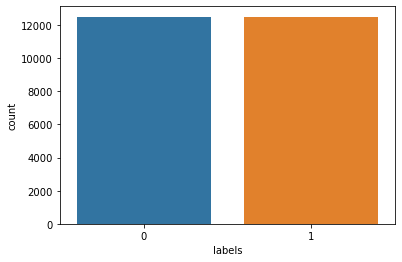

In [14]:
sns.countplot(x='labels', data=df)
#0=dog,1=cat


We can see that the data is perfectly balanced

## Data preparation

In [9]:
y = df["labels"]
X = df.drop(labels = ["labels"], axis = 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state=42)

All other data manipulations such as PCA and scaling will be performed within the pipeline before running each model

 ## Run some models without PCA

In [19]:
rf = RandomForestClassifier(criterion='entropy', max_depth=50, max_features='auto',
                       min_samples_leaf=4, min_samples_split=3,
                       n_estimators=100)
pipeline_rf = make_pipeline(StandardScaler(),rf)
pipeline_rf.fit(X_train, y_train)
print('Model Accuracy: %.3f' % pipeline_rf.score(X_test, y_test))        

Model Accuracy: 0.649


In [20]:
xgb1 = XGBClassifier(n_jobs = -1,learning_rate = 0.1, seed = 0,eval_metric='mlogloss',subsample=0.8, n_estimators=150, min_child_weight=10, max_depth=4, gamma=0.5, colsample_bytree=1.0)
pipeline_xgb1 = make_pipeline(StandardScaler(),xgb1)
pipeline_xgb1.fit(X_train, y_train)
print('Model Accuracy: %.3f' % pipeline_xgb1.score(X_test, y_test))    

C:\Users\Asaf Yekutiel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model Accuracy: 0.685


If we manage to reach a result around 68.5 with PCA we will know that we have found a good model

## Run some models with PCA

### Random Forest Classifier

In [39]:
tree_param_grid = [
    
    {
     'n_estimators': [100,150,200,250],
     'max_depth':[None,30,50,100],
     'max_features': ['auto','sqrt','log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2,3,5,7],
     'criterion' :['gini', 'entropy']  
        
    }
    
]

In [40]:
rf = RandomForestClassifier()
gridTree = RandomizedSearchCV(rf, param_distributions=tree_param_grid,scoring='accuracy', return_train_score=True, n_jobs=-1, cv=5, verbose=3, random_state=21,n_iter=50)

In [41]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=0.90),rf)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 36.4min finished


Accuracy: 0.6396


In [44]:
gridTree.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=250)

In [109]:
gridTree.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=3,
                       n_estimators=250)

In [7]:
# the best model that my RandomizedSearchCV gave me after 5-6 difrrent tries
rf_best = RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=3,
                       n_estimators=250)


In [25]:
pipeline_rf_best = make_pipeline(StandardScaler(), PCA(n_components=0.9)
                       ,rf_best)
pipeline_rf_best.fit(X_train, y_train)
print('Model Accuracy: %.3f' % pipeline_rf_best.score(X_test, y_test))

Model Accuracy: 0.647



 Result almost like that of the same model before we performed PCA

### XGB Classifier

In [ ]:
params = {
        'learning_rate':[ 0.1, 0.2, 0.3],
        'n_estimators':[100,150,200,250],
        'min_child_weight': [1,3, 5,7, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6,0.7, 0.8, 0.9 1.0],
        'max_depth': [3, 4, 5,8]
        }

In [ ]:
xgb = XGBClassifier(objective='multi:softmax',
                    silent=True, nthread=1)
grid_xgb = RandomizedSearchCV(xgb, param_distributions=params,scoring='accuracy', return_train_score=True, n_jobs=-1, cv=5, verbose=5, ,n_iter=100 )
pipe_xgb = make_pipeline(imputer,StandardScaler(), PCA(n_components=0.90),grid_xgb)
pipe_xgb.fit(X_train,y_train)
print('Model Accuracy: %.3f' % pipe_xgb.score(X_test, y_test))

In [11]:
# the best model that my RandomizedSearchCV gave me after 5 difrrent tries

xgb_best1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=250, n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None,cv=5)


In [13]:
pipeline_5 = make_pipeline(StandardScaler(), PCA(n_components=0.9)
                       ,xgb_best)
pipeline_5.fit(X_train, y_train)
print('Model Accuracy: %.3f' % pipeline_5.score(X_test, y_test))

C:\Users\Asaf Yekutiel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:51] WARNING: ..\src\learner.cc:541: 
Parameters: { cv } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:34:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.671


Lats try to improve this model by using Bagging Classifier

In [10]:
# using grid to find the best parameters
params = {'n_estimators': [10,30],
          'max_samples': [0.5, 1.0],
          'max_features': [0.5, 1.0],
          'bootstrap': [True],      
          'bootstrap_features': [True]}
xgb_clf=xgb_best

bagging_classifier_grid = GridSearchCV(BaggingClassifier(base_estimator = xgb_clf,random_state=5, n_jobs=-1), param_grid =params, cv=5, n_jobs=-1, verbose=1)
pipeline_bagging_xgb1 = make_pipeline(StandardScaler(), PCA(n_components=0.90)
                       ,bagging_classifier_grid)  
pipeline_bagging_xgb1.fit(X_train, y_train)

print('Model Accuracy: %.3f' % pipeline_bagging_xgb1.score(X_test, y_test))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 871.9min finished


Model Accuracy: 0.683


This is a great result.<br/> 
 Result almost like that of the same model before we performed PCA

In [11]:
bagging_classifier_grid.best_estimator_

BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                               colsample_bylevel=1,
                                               colsample_bynode=1,
                                               colsample_bytree=0.7, cv=5,
                                               gamma=0, gpu_id=-1,
                                               importance_type='gain',
                                               interaction_constraints='',
                                               learning_rate=0.1,
                                               max_delta_step=0, max_depth=8,
                                               min_child_weight=1, missing=nan,
                                               monotone_constraints='()',
                                               n_estimators=250, n_jobs=-1,
                                               num_class=3, num_parallel_tree=1,
                                         

In [12]:
xgb_best=BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                               colsample_bylevel=1,
                                               colsample_bynode=1,
                                               colsample_bytree=0.7, cv=5,
                                               gamma=0, gpu_id=-1,
                                               importance_type='gain',
                                               interaction_constraints='',
                                               learning_rate=0.1,
                                               max_delta_step=0, max_depth=8,
                                               min_child_weight=1, 
                                               monotone_constraints='()',
                                               n_estimators=250, n_jobs=-1,
                                               num_class=3, num_parallel_tree=1,
                                               objective='multi:softmax',
                                               random_state=0, reg_alpha=0,
                                               reg_lambda=1,
                                               scale_pos_weight=None,
                                               subsample=1, tree_method='exact',
                                               validate_parameters=1,
                                               verbosity=None),
                  bootstrap_features=True, n_estimators=30, n_jobs=-1,
                  random_state=5)

### AdaBoostClassifier

In [63]:


abc = AdaBoostClassifier(n_estimators=150, base_estimator=rf_best,learning_rate=0.1,)
pipeline_abc = make_pipeline(StandardScaler(), PCA(n_components=0.9),abc)
scores = cross_val_score(pipeline_abc,X,y ,cv=3)


In [64]:
scores

array([0.64458843, 0.64190568, 0.63974559])

### KNeighbors Classifier

In [75]:
knn2 =KNeighborsClassifier()
k_range = list(range(30, 50))
weight_options = ['distance']
metric_options = ['euclidean','manhattan']
leaf_size = list(range(20,50))
param_grid = dict(n_neighbors=k_range, weights=weight_options,metric = metric_options,leaf_size=leaf_size)

In [76]:

gridKnn = RandomizedSearchCV(knn2, param_grid, cv=5, scoring='accuracy',verbose=1, return_train_score=True,n_iter=10,n_jobs=-1)
pipe_knn = make_pipeline(imputer,StandardScaler(), PCA(n_components=0.90),gridKnn)
pipe_knn.fit(X_train,y_train)
y_pred=pipe_knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 46.9min finished


Accuracy: 0.6232


In [83]:
gridKnn.best_estimator_


KNeighborsClassifier(leaf_size=46, metric='euclidean', n_neighbors=40,
                     weights='distance')

In [78]:
k_range = list(range(30,54))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,leaf_size=46, metric='euclidean', weights='distance')
    pipeline_knn1 = make_pipeline(StandardScaler(), PCA(n_components=0.9),knn)
    scores = scores = cross_val_score(pipeline_knn1,X,y ,cv=3, scoring='accuracy')
    k_scores.append(scores.mean())
max_value = max(k_scores)
max_index = k_scores.index(max_value)+1
print("The optimal number of neighbors is {} and the score is {}".format(max_index , max_value))
`

The optimal number of neighbors is 13 and the score is 0.6203204211681786


Text(0, 0.5, 'Cross-Validated Accuracy')

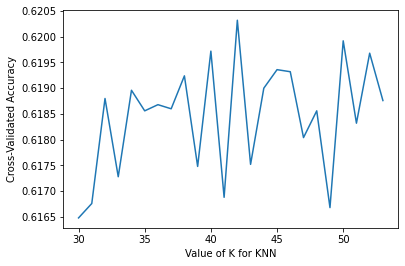

In [79]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [81]:
# the best Knn model that I found with RandomizedSearchCV after a few tries
knn = KNeighborsClassifier(leaf_size=46, metric='euclidean', n_neighbors=43,weights='distance')
pipe_knn1 = make_pipeline(imputer,StandardScaler(), PCA(n_components=0.90),knn)
pipe_knn1.fit(X_train,y_train)
y_pred=pipe_knn1.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6186


 ### GaussianNB

In [14]:
from sklearn.naive_bayes import GaussianNB  
gnb = GaussianNB()  

In [22]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=150)
}

In [23]:
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=5, n_jobs=-1)


In [37]:
imputer = SimpleImputer()
pipe_gnb = make_pipeline(imputer,StandardScaler(), PCA(n_components=0.90),GaussianNB(var_smoothing=0.0657933224657568))
pipe_gnb.fit(X_train,y_train)
y_pred=pipe_gnb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6024


### Voting classfier 

In [68]:
# hard voting 
rnd_clf = rf_best
xgb_clf = bagging_classifier_grid.best_estimator_
adabost = abc 
voting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('xgb', xgb_clf),('adabost', adabost)],
    voting='hard')
pipeline_VH = make_pipeline(StandardScaler(), PCA(n_components=0.90)
                       ,voting_clf)
pipeline_VH.fit(X_train, y_train)
print('Model Accuracy: %.3f' % pipeline_VH.score(X_test, y_test))

Model Accuracy: 0.673


### StackingClassifier

In [27]:
rnd_clf = rf_best
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', 
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=250, n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, )
adabost = AdaBoostClassifier(n_estimators=150, base_estimator=rf_best,learning_rate=0.1,) 
knn = KNeighborsClassifier(leaf_size=46, metric='euclidean', n_neighbors=43,weights='distance')
estimator_list = [
    ('knn',knn),
    ('xgb_tund',xgb_clf),
    ('rf_tund',rnd_clf ),
    ('adabost',adabost)
 
]

# Build stack model
stack_model = StackingClassifier(estimators=estimator_list, final_estimator=LogisticRegression(),cv =5,n_jobs=-1,verbose=3)
pipeline_SM = make_pipeline(StandardScaler(), PCA(n_components=0.90)
                       ,stack_model)
pipeline_SM.fit(X_train, y_train)
print('Model Accuracy: %.3f' % pipeline_SM.score(X_test, y_test))



Model Accuracy: 0.663


In [26]:
xgb_clf1=XGBClassifier(objective='binary:logistic',silent=True, nthread=1,subsample=1,n_estimators=150,min_child_weight=5,colsample_bytree = 1.0,learning_rate=0.2,gamma=2)
gs =GaussianNB(var_smoothing=0.0657933224657568)
estimator_list = [
    ('knn',knn),
    ('xgb_tund',xgb_clf),
     ('rf_tund',rnd_clf),
    ('gs',gs)
]
    
# Build stack model
stack_model2 = StackingClassifier(estimators=estimator_list, final_estimator=LogisticRegression(),cv =5,n_jobs=-1,verbose=3)
pipeline_SM2 = make_pipeline(StandardScaler(), PCA(n_components=0.90)
                       ,stack_model)
pipeline_SM2.fit(X_train, y_train)
print('Model Accuracy: %.3f' % pipeline_SM2.score(X_test, y_test))

Model Accuracy: 0.662


## Conclusions


We got the best result using XGB with Bagging Classifier drid running on it
